In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json

import os

The 18 identifiers that make health information PHI are:

 - Names
 - Dates, except year
 - Telephone numbers
 - Geographic data
 - FAX numbers
 - Social Security numbers
 - Email addresses
 - Medical record numbers
 - Account numbers
 - Health plan beneficiary numbers
 - Certificate/license numbers
 - Vehicle identifiers and serial numbers including license plates
 - Web URLs
 - Device identifiers and serial numbers
 - Internet protocol addresses
 - Full face photos and comparable images
 - Biometric identifiers (i.e. retinal scan, fingerprints)
 - Any unique identifying number or code

In [6]:
deid_dict = {
    "de-identification_root_concept": ["name", "contact_details", "healthcare_identifier", "date"],
    "name": ["fore_name", "surname"],
    "contact_details": ["address", "telephone_number", "email", "identification"],
    "address": ["address_line", "postcode"],
    "identification": ["passport_number", "driving_licence_number"],
    "healthcare_identifier": ["nhs_number", "hospital_number", "emergency_department_number"],
    "date": ["date_of_birth"],
    }


In [26]:
print(deid_dict.keys())


dict_keys(['de-identification_root_concept', 'name', 'contact_details', 'address', 'identification', 'healthcare_identifier', 'date'])


#### Meta_annotations will hold the contextual information of the concept.
"Subject": ["patient", "family", "clinician"] (unselected meta_ann will mean "other/ N/A")


/home/jonnysheldon/Documents/MedCAT/Creating_a_de-identification_terminology
                              from                           to
0   de-identification_root_concept                         name
1   de-identification_root_concept              contact_details
2   de-identification_root_concept        healthcare_identifier
3   de-identification_root_concept                         date
4                             name                    fore_name
5                             name                      surname
6                  contact_details                      address
7                  contact_details             telephone_number
8                  contact_details                        email
9                  contact_details               identification
10                         address                 address_line
11                         address                     postcode
12                  identification              passport_number
13                  identif

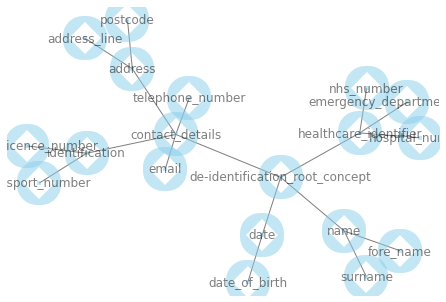

In [23]:
# TODO: visualise the terminology hierarchy
# https://python-graph-gallery.com/321-custom-networkx-graph-appearance/
print(os.getcwd())
df = pd.read_csv("cbd_diagram.csv")
print(df)
# Build your graph
G=nx.from_pandas_edgelist(df, 'from', 'to')#, edge_attr=True)
 
# Graph with Custom nodes:
nx.draw(G, with_labels=True, node_size=10, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=40)
plt.show()

In [9]:
# TODO: Create a JSON file with the terminology structure with only the Fully specified names (FSN)
deid_json = json.dumps(deid_dict, sort_keys=True)
print(deid_json)

# TODO: enrich the terminology with synonyms
# TODO: create a CUI convention which reflects terminology structure
# code consists of 3 parts A = the name of the anonymisation dict. second letter = the term it belongs to (either the root, or the 1st child term) then a 4 letter code linking the term into the rest of the dictionary [first_parent][second parent][third parent][fourth parent]
deid_cui_dict = {
    "de-identification_root_concept": "A-R-0000",
    "name": "A-N-1000",
    "contact_details": "A-C-2000",
    "healthcare_identifier": "A-H-3000",
    "date": "A-D-4000",
    "fore_name": "A-N-1100",
    "surname": "A-N-1200",
    "address": "A-C-2100",
    "address_line": "A-C-2110",
    "postcode": "A-C-2120",
    "telephone_number":"A-C-2200",
    "email": "A-C-2300",
    "identification": "A-C-2400",
    "passport_number": "A-C-2410",
    "driving_licence_number": "A-C-2420",
    "nhs_number": "A-H-3100",
    "hospital_number": "A-H-3200",
    "emergency_department_number": "A-H-3300",
    "date_of_birth": "A-D-4100"
    }
# TODO: Create a csv file with each concept and concept unique identifier

{"address": ["address_line", "postcode"], "contact_details": ["address", "telephone_number", "email", "identification"], "date": ["date_of_birth"], "de-identification_root_concept": ["name", "contact_details", "healthcare_identifier", "date"], "healthcare_identifier": ["nhs_number", "hospital_number", "emergency_department_number"], "identification": ["passport_number", "driving_licence_number"], "name": ["fore_name", "surname"]}


# Create a CDB CSV format file following the structure:

|cui|str|onto|tty|tui|sty|desc|
|--|--|--|--|--|--|--|

__cui__ - The concept unique identifier, this is simply an ID in your database

__str__ - String/Name of that concept. It is important to write all possible names and abbreviations for a concept of interest.

__onto__ - Source ontology, e.g. HPO, SNOMED, HPC,...

__tty__ - Term type e.g. PN - Primary Name. Primary names are important and I would always recommend to add this fields when creating your CDB. Important to distinguish from synoymns. 

__tui__ - Semantic type identifier - A unique identifier code for each semantic type.

__sty__ - Semantic type - AKA fully specified name of top level concept group

__desc__ - Description of this concept


In [15]:
# dictionary of root concepts for the de-id cui database
deid_sty = {
    "de-identification_root_concept": "A-R-0000",
    "name": "A-R-0000",
    "contact_details": "A-R-0000",
    "healthcare_identifier": "A-R-0000",
    "date": "A-R-0000",
    "fore_name": "A-N-1000",
    "surname": "A-N-1000",
    "address": "A-C-2000",
    "address_line": "A-C-2100",
    "postcode": "A-C-2100",
    "telephone_number":"A-C-2000",
    "email": "A-C-2000",
    "identification": "A-C-2000",
    "passport_number": "A-C-2400",
    "driving_licence_number": "A-C-2400",
    "nhs_number": "A-H-3000",
    "hospital_number": "A-H-3000",
    "emergency_department_number": "A-H-3000",
    "date_of_birth": "A-D-4000"
    }
# dictionary of descriptions for the de-id cui database
deid_desc = {
    "de-identification_root_concept": "root concept of de-identification",
    "name": "surname and forname",
    "contact_details": "non hospital identification and contact details",
    "healthcare_identifier": "hospital derived ID",
    "date": "personal dates",
    "fore_name": "given name including middle names",
    "surname": "all surnames",
    "address": "address and postcode",
    "address_line": "all address line items including city and country",
    "postcode": "all postcodes",
    "telephone_number":"telepone numbers both mobile and landline",
    "email": "email addresses",
    "identification": "non hospital identification",
    "passport_number": "possport number",
    "driving_licence_number": "driving licence",
    "nhs_number": "nhs numbers",
    "hospital_number": "hospital number from kings college hospital and other trusts",
    "emergency_department_number": "number given by kings college hospital emergency number",
    "date_of_birth": "date of birth"
    }

In [26]:
df = pd.DataFrame(deid_cui_dict.items(), columns=['str', 'cui'])
df["onto"] = "cat_anon"
df["tty"] ="PN"
df["tui"] = PN_df["cui"]
sty_df = pd.DataFrame(deid_sty.items(), columns=['str', 'sty'])
desc_df = pd.DataFrame(deid_desc.items(), columns=['str', 'desc'])
df = df.merge(sty_df, left_on="str",right_on="str")
df = df.merge(desc_df, left_on="str",right_on="str")
print(df)

                               str       cui      onto tty       tui  \
0   de-identification_root_concept  A-R-0000  cat_anon  PN  A-R-0000   
1                             name  A-N-1000  cat_anon  PN  A-N-1000   
2                  contact_details  A-C-2000  cat_anon  PN  A-C-2000   
3            healthcare_identifier  A-H-3000  cat_anon  PN  A-H-3000   
4                             date  A-D-4000  cat_anon  PN  A-D-4000   
5                        fore_name  A-N-1100  cat_anon  PN  A-N-1100   
6                          surname  A-N-1200  cat_anon  PN  A-N-1200   
7                          address  A-C-2100  cat_anon  PN  A-C-2100   
8                     address_line  A-C-2110  cat_anon  PN  A-C-2110   
9                         postcode  A-C-2120  cat_anon  PN  A-C-2120   
10                telephone_number  A-C-2200  cat_anon  PN  A-C-2200   
11                           email  A-C-2300  cat_anon  PN  A-C-2300   
12                  identification  A-C-2400  cat_anon  PN  A-C-

In [29]:
# read in list
def read_list(name, encode):
    with open(name, encoding = encode) as file:
        lines = [line.rstrip('\n') for line in file]
        return lines

In [34]:
# read in list of first names
def list_2_df(lst,cui, sty):
    """
    Takes a list of words, the cui (concept) and sty (root concept) nad turns this into a cat_anon dataframe
    """
    temp_df = pd.DataFrame({'str':lst})
    temp_df["cui"] = cui
    temp_df["onto"] = "cat_anon"
    temp_df["tty"] ="SN"
    temp_df["tui"] = temp_df["cui"]
    temp_df["sty"] = sty
    temp_df["desc"] = ""
    return temp_df

              str       cui      onto tty       tui       sty desc
0         ayannia  A-N-1100  cat_anon  SN  A-N-1100  A-N-1000     
1          kaelyb  A-N-1100  cat_anon  SN  A-N-1100  A-N-1000     
2           merid  A-N-1100  cat_anon  SN  A-N-1100  A-N-1000     
3         kayleeh  A-N-1100  cat_anon  SN  A-N-1100  A-N-1000     
4         sumeeta  A-N-1100  cat_anon  SN  A-N-1100  A-N-1000     
...           ...       ...       ...  ..       ...       ...  ...
129428  hantiileh  A-N-1100  cat_anon  SN  A-N-1100  A-N-1000     
129429   johnanna  A-N-1100  cat_anon  SN  A-N-1100  A-N-1000     
129430    bidzina  A-N-1100  cat_anon  SN  A-N-1100  A-N-1000     
129431   tasnimah  A-N-1100  cat_anon  SN  A-N-1100  A-N-1000     
129432   youngran  A-N-1100  cat_anon  SN  A-N-1100  A-N-1000     

[129433 rows x 7 columns]


In [ ]:
first_names = read_list("cleaned_output/cleaned_first_name.txt","UTF-8")
last_names = read_list("cleaned_output/cleaned_last_name.txt","UTF-8")
hosp_num = read_list("cleaned_output/cleaned_last_name.txt","UTF-8")
nhs_num = read_list("cleaned_output/nhs_numbers.txt","UTF-8")
postcodes = read_list("cleaned_output/postcodes.txt","UTF-8")

In [ ]:
first_df = list_2_df(first_names, "A-N-1100", "A-N-1000")
last_df = list_2_df(last_names, "A-N-1200", "A-N-1000")
hosp_df = list_2_df(hosp_num, "A-H-3200", "A-H-3000")
nhs_df = list_2_df(nhs_num, "A-H-3100", "A-H-3000")
postcode_df = list_2_df(postcodes, "A-C-2120", "A-C-2100")
print(test_df)

In [ ]:
dataframe_list = []